In [160]:
# 파일 로드
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [161]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
import os
from os.path import join
from glob import glob
from tqdm.notebook import tqdm
import math
import random

feature extraction

In [162]:
#이미지에 minutiae에 해당하는 좌표 표시
def draw_minutiae(fingerprint, minutiae, termination_color = (255,0,0), bifurcation_color = (255,255,0)):
    res = cv2.cvtColor(fingerprint, cv2.COLOR_GRAY2BGR)
    plt.imshow(res)
    img_points = np.zeros((256, 256, 3), np.uint8)
    for x, y, t, *d in minutiae:
        if t:
          cv2.circle(res,(x,y),2, termination_color,-1)
        else:
          cv2.circle(res, (x,y), 2,bifurcation_color, -1)
    return res

In [163]:
# P주변의 값을 0, 혹은 255로 변환해주는 필터 생성
cn_filter = np.array([[  1,  2,  4],
                      [128,  0,  8],
                      [ 64, 32, 16]
                     ])

def compute_crossing_number(values):
    return np.count_nonzero(values < np.roll(values, -1))

In [164]:
def fingerprint_minutiae(img_gray):
  plt.rcParams['figure.figsize']=(8,8)


  #----------------------------
  # 가우스 노이즈 제거 

  img_gauss = cv2.GaussianBlur(img_gray, (3, 3), 0) 

  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  img_cl = clahe.apply(img_gauss)

  plt.subplot(3,4,1)
  plt.imshow(img_cl, cmap='gray')

  #------------------------------
  # 이진화
  img_adpt = cv2.adaptiveThreshold(img_cl, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 5)
  img_adpt = 255 - img_adpt

  plt.subplot(3,3,1)
  plt.imshow( img_adpt, cmap='gray')

  #--------------------------------
  # 융선 내부 노이즈 제거
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))

  img_res = img_adpt.copy()

  img_res = cv2.medianBlur(img_res, 3)
  img_res = cv2.morphologyEx(img_res, cv2.MORPH_CLOSE, kernel, iterations=1)
  img_res = cv2.medianBlur(img_res, 3)
  img_res = cv2.medianBlur(img_res, 3)
  plt.subplot(3,3,2)
  plt.imshow(img_res, cmap='gray')
  #----------------------------------
  # skeletonization

  img_thinned = np.where(img_res==255, 1, img_res)
  img_thinned = skeletonize(img_thinned)
  img_thinned = img_thinned.astype(np.uint8)
  plt.subplot(3,3,3)
  plt.imshow(img_thinned, cmap='gray')
  num = random.randrange(1, 101)
  plt.imsave("./skel"+str(num)+".jpg",img_thinned)
  

  #===================================================
  # minutiae 검출

  
  # 각 바이트 값을 CN에 매핑하는 lookup table 생성
  all_8_neighborhoods = [np.array([int(d) for d in f'{x:08b}'])[::-1] for x in range(256)]
  cn_lut = np.array([compute_crossing_number(x) for x in all_8_neighborhoods]).astype(np.uint8)

  
  skeleton01 = np.where(img_thinned!=0, 1, 0).astype(np.uint8)
  cn_values = cv2.filter2D(skeleton01, -1, cn_filter, borderType = cv2.BORDER_CONSTANT)
  cn = cv2.LUT(cn_values, cn_lut)
  cn[img_thinned==0] = 0

  # CN(P) == 1 --> 끝점, CN(P) == 3 --> 분기점
  minutiae = [(x,y,cn[y,x]==1) for y, x in zip(*np.where(np.isin(cn, [1,3])))]


  #지문 엣지 검출
  gx, gy = cv2.Sobel(img_thinned, cv2.CV_32F, 1, 0), cv2.Sobel(img_thinned, cv2.CV_32F, 0, 1)

  # 각 픽셀에 대한 gradient 크기 계산
  gx2, gy2 = gx**2, gy**2
  gm = np.sqrt(gx2 + gy2)

  #지문 영역 얻기 위한 이미지 블러링
  sum_gm = cv2.boxFilter(gm, -1, (25, 25), normalize = False)
  
  plt.subplot(3,3,4)
  plt.imshow(sum_gm, cmap="gray")
  
  thr = sum_gm.max() * 0.45
  mask = cv2.threshold(sum_gm, thr, 255, cv2.THRESH_BINARY)[1].astype(np.uint8)
  mask_distance = cv2.distanceTransform(cv2.copyMakeBorder(mask, 1, 1, 1, 1, cv2.BORDER_CONSTANT), cv2.DIST_C, 3)[1:-1,1:-1]
 
  plt.subplot(3,3,5)
  plt.imshow(mask,cmap="gray")
  
  img_skel = cv2.imread("./skel"+str(num)+".jpg", cv2.IMREAD_GRAYSCALE)
 
  #지문 이외 영역 필터링
  filtered_minutiae = list(filter(lambda m: mask_distance[m[1], m[0]]>10, minutiae))
  plt.subplot(3,3,7)
  plt.imshow(draw_minutiae(img_skel, minutiae))
  plt.subplot(3,3,8)
  plt.imshow(draw_minutiae(img_skel, filtered_minutiae))
  
  filtered_minutiae_points=[]
  for x in filtered_minutiae:
    filtered_minutiae_points+=[(x[0],x[1])]

  return draw_minutiae(img_skel, filtered_minutiae), filtered_minutiae



In [165]:
train_path = '/content/gdrive/MyDrive/생체/train_ref'
test2_path = '/content/gdrive/MyDrive/생체/test2_1'

list_train = sorted(glob(join(train_path, '*.BMP')))
list_test2 = sorted(glob(join(test2_path, '*.BMP')))
print(len(list_train), len(list_test2))

477 714


/content/gdrive/MyDrive/생체/test2_1/100_type1.BMP 100 /content/gdrive/MyDrive/생체/train_ref/100.BMP


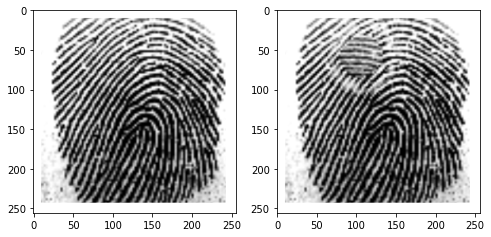

In [166]:
target_path = list_test2[0]
basename = os.path.basename(target_path).split('_')[0]
train_sample_path = join(train_path, basename + '.BMP')
print(target_path, basename, train_sample_path)
img_train = cv2.imread(train_sample_path, cv2.IMREAD_GRAYSCALE)
img_test = cv2.imread(target_path, cv2.IMREAD_GRAYSCALE)

plt.subplot(1,2,1)
plt.imshow(img_train, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img_test, cmap='gray')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

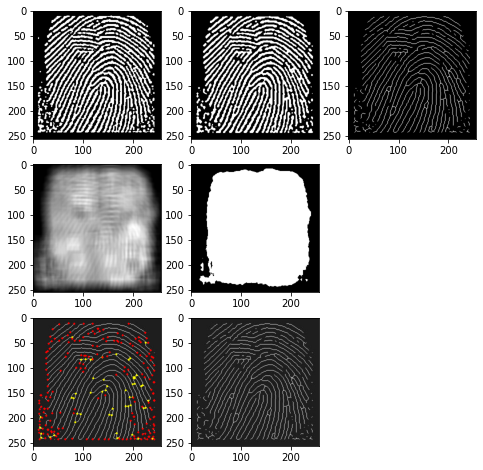

In [167]:
train_fp, train_fp_m =(fingerprint_minutiae(img_train))
test_fp, test_fp_m =(fingerprint_minutiae(img_test))


In [168]:
def intersect(train,test):
  intersection = list(set(train) & set(test))
  if(len(intersection)/len(test)*100 > 60):
    result=True
  else:
    result=False
  return intersection, len(intersection)/len(test)*100, result
fp_intersect_m, fp_acr, fp_result=intersect(train_fp_m,test_fp_m)

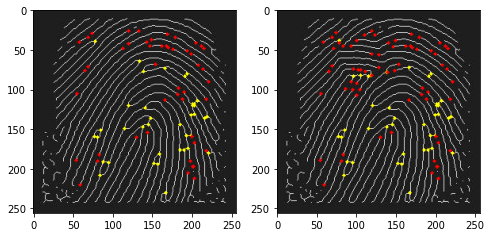

In [169]:
plt.subplot(1,2,1)
plt.imshow(train_fp, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(test_fp, cmap='gray')

65.13761467889908 True


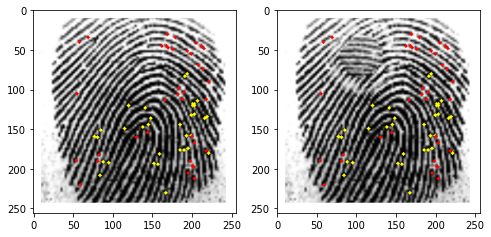

In [170]:
print(fp_acr,fp_result)
plt.subplot(1,2,1)
plt.imshow(draw_minutiae(img_train,fp_intersect_m))
plt.subplot(1,2,2)
plt.imshow(draw_minutiae(img_test,fp_intersect_m))